# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import functional as TF
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
import os
from tqdm.notebook import tqdm
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img1, img2):
    
    img1 = TF.to_pil_image(img1, mode='L')
    img2 = TF.to_pil_image(img2, mode='L')
    
    plt.subplot(121)
    plt.imshow(img1)
    
    plt.subplot(122)
    plt.imshow(img2)
    
    plt.show()    
    
def show_plot(train_loss, val_loss):
    plt.figure(figsize=(15, 5))
    plt.plot(train_loss, label='train_loss')
    plt.plot(val_loss, label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

def show_pred(test_results_0, test_results_1):
    plt.figure(figsize=(15, 5))
    plt.plot(test_results_0, label='pred distance of similar floorplans')
    plt.plot(test_results_1, label='pred distance of different floorplans')
    plt.legend()
    plt.grid()
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./data_madori/train/"
    val_dir = './data_madori/val/'
    testing_dir = "./data_madori/test/"
    checkpoint_dir = './checkpoint'
    batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class MadoriDataset(Dataset):
    def __init__(self, data_dir, img_size=(256, 256)):
        self.img_paths = [os.path.join(data_dir, x) for x in os.listdir(data_dir)]
        self.img_size = (256, 256)
        
    def __len__(self):
        return len(self.img_paths)
    
    def _resize(self, img):
        w, h = img.size
        if w < h:
            a = 256.0 / h
            b = int(w * a)
            img = img.resize((b, 256), Image.BILINEAR)
        else:
            a = 256.0 / w
            b = int(h * a)
            img = img.resize((256, b), Image.BILINEAR)
        return img
    
    def _pad(self, img):
        w, h = img.size
        img = TF.pad(img, (0,0,256-w,0), padding_mode='edge') if h == 256 else \
               TF.pad(img, (0,0,0,256-h), padding_mode='edge')
        
        if img.size != self.img_size:
            print('|-'*20, img.size, (w, h)) # (97, 256) (97, 249)
        return img
    
    def _transform(self, img):
        return self._pad(self._resize(img))
    
    def _aug_img(self, image):
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([90, 180, 270]))
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        return image
    
    def __getitem__(self, idx):
        img_path1 = self.img_paths[idx]
        img1 = self._transform(Image.open(img_path1).convert('L'))
        label = random.randint(0, 1)
        if label:
            # choose different floorplan
            img_path2 = img_path1
            while img_path2 == img_path1:
                img_path2 = random.choice(self.img_paths)
            img2 = self._transform(Image.open(img_path2).convert('L'))
        else:
            # choose similar floorplan by augmentation
            img2 = self._aug_img(img1)
        img1, img2 = TF.to_tensor(img1), TF.to_tensor(img2)
        return img1, img2, torch.from_numpy(np.array([label],dtype=np.float32))

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

torch.Size([64, 1, 256, 256]) torch.Size([64, 1, 256, 256])
tensor([1.])


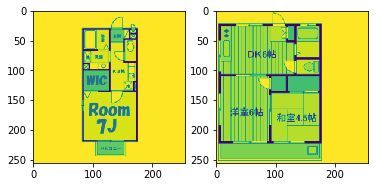

tensor([0.])


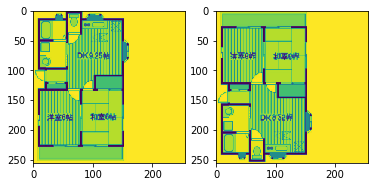

tensor([0.])


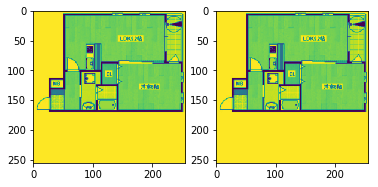

In [5]:
dset_loader = DataLoader(MadoriDataset(Config.training_dir), 
                           batch_size=Config.batch_size, 
                           shuffle=True)

for i, batch in enumerate(dset_loader):
    img1, img2, label = batch
    print(img1.size(), img2.size())
    for k in range(3):
        print(label[k])
        imshow(img1[k], img2[k])
    break

## Neural Net Definition
We will use a standard convolutional neural network

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*256*256, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - 
                                        euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Training Time!

In [8]:
train_dataloader = DataLoader(MadoriDataset(Config.training_dir), 
                                shuffle=True,
                                batch_size=Config.batch_size)

val_dataloader = DataLoader(MadoriDataset(Config.val_dir), 
                                shuffle=False,
                                batch_size=Config.batch_size)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss(margin=5)
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [11]:
train_loss_history, val_loss_history = [], []
lowest_epoch_train_loss = lowest_epoch_val_loss = float('inf')

In [12]:
for epoch in tqdm(range(Config.train_number_epochs)):
    # training
    net.train()
    epoch_train_loss = 0
    for batch_no, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        batch_train_loss = criterion(output1,output2,label)
        epoch_train_loss += batch_train_loss.item()
        batch_train_loss.backward()
        optimizer.step()
    epoch_train_loss /= (batch_no + 1)
    if epoch_train_loss < lowest_epoch_train_loss:
        lowest_epoch_train_loss = epoch_train_loss
        torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_train.pth')
    train_loss_history.append(epoch_train_loss)
    
    # validation
    net.eval()
    with torch.no_grad():
        epoch_val_loss = 0
        for batch_no, data in enumerate(val_dataloader):
            img0, img1, label = data
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            output1,output2 = net(img0,img1)
            batch_val_loss = criterion(output1,output2,label)
            epoch_val_loss += batch_val_loss
        epoch_val_loss /= (batch_no + 1)
        if epoch_val_loss < lowest_epoch_val_loss:
            lowest_epoch_val_loss = epoch_val_loss
            torch.save(net.state_dict(), f'{Config.checkpoint_dir}/best_val.pth')
        val_loss_history.append(epoch_val_loss)
    print(f'Epoch {epoch} training loss is {epoch_train_loss}, validation loss is {epoch_val_loss}')

Epoch 0 training loss is 146.91822101451731, validation loss is 14.278058052062988
Epoch 1 training loss is 41.55444021578188, validation loss is 9.740939140319824
Epoch 2 training loss is 25.518583792227286, validation loss is 9.971570014953613
Epoch 3 training loss is 20.087691713262487, validation loss is 8.333826065063477
Epoch 4 training loss is 13.061243463445592, validation loss is 6.608893394470215
Epoch 5 training loss is 11.494854980044895, validation loss is 5.7320404052734375
Epoch 6 training loss is 7.300394111209446, validation loss is 4.590822219848633
Epoch 7 training loss is 6.336841804009897, validation loss is 3.5454134941101074
Epoch 8 training loss is 5.133901785921167, validation loss is 3.267422676086426
Epoch 9 training loss is 4.5448782885516135, validation loss is 1.699303150177002
Epoch 10 training loss is 3.3197118926931313, validation loss is 2.6936111450195312
Epoch 11 training loss is 3.0853681431876288, validation loss is 1.9894217252731323
Epoch 12 trai

Epoch 98 training loss is 0.3940162330313965, validation loss is 0.35315826535224915
Epoch 99 training loss is 0.5263732351638652, validation loss is 0.6062905788421631



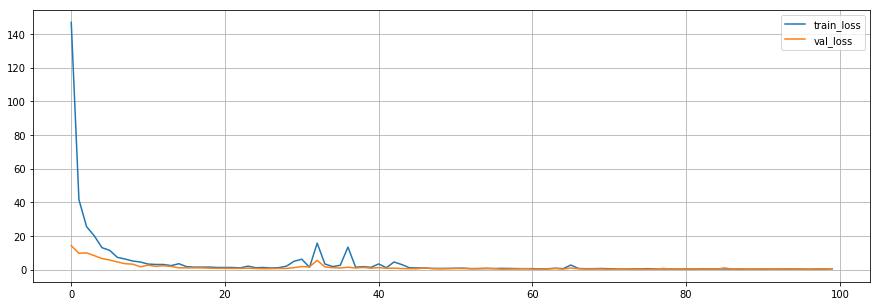

In [20]:
show_plot(train_loss_history[:], val_loss_history[:])

## Some simple testing

In [14]:
epoch_test = 0
net = SiameseNetwork().to(device)
net.load_state_dict(torch.load(f'{Config.checkpoint_dir}/best_val.pth'))
test_dataloader = DataLoader(MadoriDataset(Config.testing_dir), 
                                shuffle=False,
                                batch_size=1)

In [15]:
net.eval()
test_results_0 = []
test_results_1 = []
with torch.no_grad():
    for batch_no, data in enumerate(test_dataloader):
        #if batch_no > 10: break
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
        output1,output2 = net(img0,img1)
        euclidean_distance = F.pairwise_distance(output1, output2)
        
        img0, img1 = img0.cpu(), img1.cpu()
        print(f'label: {label.item()}, pred distance: {euclidean_distance.item()}')
        if label.item() == 1.0:
            test_results_1 += [euclidean_distance.item()]
        else:
            test_results_0 += [euclidean_distance.item()]
        #imshow(img0[0], img1[0])

label: 0.0, pred distance: 0.32837337255477905
label: 0.0, pred distance: 2.2360679849953158e-06
label: 0.0, pred distance: 2.2360679849953158e-06
label: 1.0, pred distance: 14.043035507202148
label: 1.0, pred distance: 9.194500923156738
label: 0.0, pred distance: 0.5762848854064941
label: 0.0, pred distance: 0.2497706562280655
label: 1.0, pred distance: 8.277841567993164
label: 1.0, pred distance: 15.570755004882812
label: 0.0, pred distance: 0.9178736805915833
label: 1.0, pred distance: 11.428606033325195
label: 0.0, pred distance: 0.4851226806640625
label: 0.0, pred distance: 0.5366057753562927
label: 0.0, pred distance: 0.3968070149421692
label: 0.0, pred distance: 0.612093985080719
label: 0.0, pred distance: 0.40325888991355896
label: 0.0, pred distance: 0.6864023804664612
label: 0.0, pred distance: 0.2975783944129944
label: 0.0, pred distance: 0.2924923598766327
label: 1.0, pred distance: 7.353854179382324
label: 1.0, pred distance: 12.3873872756958
label: 1.0, pred distance: 8.0

label: 0.0, pred distance: 0.4689143896102905
label: 1.0, pred distance: 29.616832733154297
label: 0.0, pred distance: 0.3770073354244232
label: 0.0, pred distance: 0.24715900421142578
label: 0.0, pred distance: 0.5830931663513184
label: 1.0, pred distance: 9.853602409362793
label: 0.0, pred distance: 0.3173445761203766
label: 0.0, pred distance: 0.7993679046630859
label: 1.0, pred distance: 5.600019454956055
label: 1.0, pred distance: 21.88019371032715
label: 1.0, pred distance: 9.905254364013672
label: 1.0, pred distance: 9.197961807250977
label: 1.0, pred distance: 23.68665885925293
label: 0.0, pred distance: 0.73506760597229
label: 1.0, pred distance: 5.415112495422363
label: 0.0, pred distance: 0.4374086856842041
label: 0.0, pred distance: 0.4178103804588318
label: 0.0, pred distance: 2.2360679849953158e-06
label: 1.0, pred distance: 9.059171676635742
label: 0.0, pred distance: 0.18474507331848145
label: 0.0, pred distance: 2.2360679849953158e-06
label: 0.0, pred distance: 2.23606

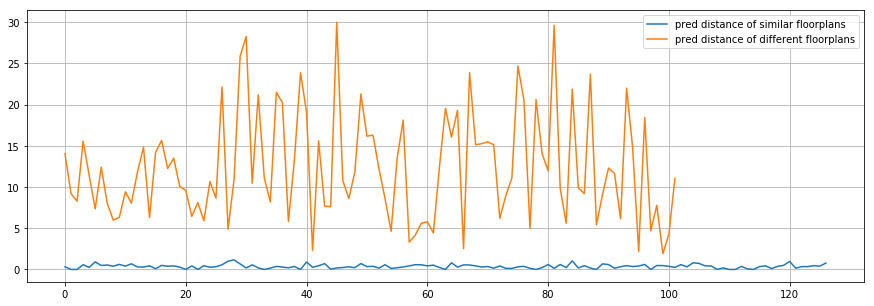

In [16]:
show_pred(test_results_0, test_results_1)

In [17]:
# margin を大きくして再学習